In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
conn = engine.connect()
# reflect the tables
Base = automap_base()
Base.prepare(autoload_with = engine)

In [6]:
# View all of the classes that automap found
# dir(Base)
# dir(Base.classes.measurement)
# Base.classes.measurement.__repr__

Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
date_last = session.query(measurement.date).order_by(measurement.date.desc()).first()
date_last[0]

'2017-08-23'

In [10]:
# dir(measurement)

Text(0, 0.5, 'Inches')

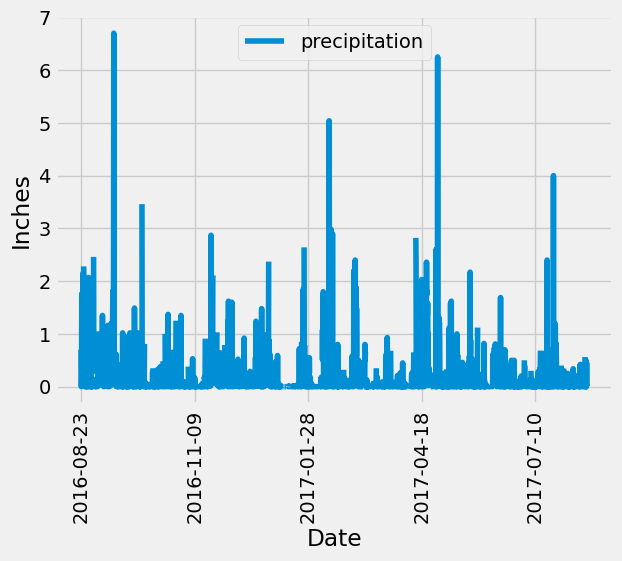

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
data = session.query(measurement.date, measurement.prcp).\
filter(measurement.date >= (last_year)).order_by(measurement.date.desc())

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(data, columns=['date', 'precipitation'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by=['date'])

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(
x = 'date',
y = 'precipitation',
rot=90)
plt.xlabel('Date')
plt.ylabel('Inches')

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
inspector = inspect(engine)

In [14]:
# Using the inspector to print the column names within the 'dow' table and its types
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [15]:
# Design a query to calculate the total number of stations in the dataset
# stations = session.query(func.count(station.station)).first()
# stations
stations_count = session.query(station.station).count()
stations_count

9

In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
counts = [station.station, func.count(measurement.station)]
active_stats = session.query(*counts).filter(station.station == measurement.station).group_by(station.station).\
    order_by(func.count(measurement.station).desc()).all()
active_stats

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
summary_stats = [func.min(measurement.tobs),
                func.max(measurement.tobs),
                func.avg(measurement.tobs)]

station_stats = session.query(*summary_stats).filter(measurement.station == 'USC00519281').all()
station_stats

[(54.0, 85.0, 71.66378066378067)]

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_yearlast = session.query(measurement.date, measurement.tobs).filter(measurement.station == 'USC00519281', \
                                                        measurement.date >= last_year).all()

station_yearlast = pd.DataFrame(station_yearlast, columns=['date', 'temperature'])
station_yearlast.head()

,date,temperature
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


Text(0.5, 0, 'Temperature')

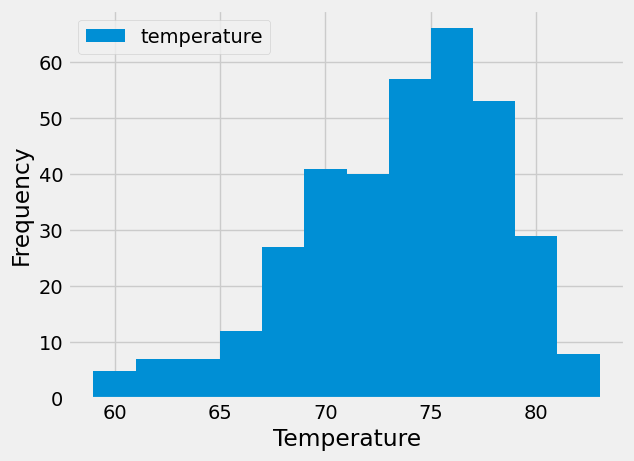

In [19]:
station_yearlast.plot.hist(bins=12)
plt.xlabel('Temperature')

# Close Session

In [20]:
# Close Session
session.close()